# Using K-Nearest Neighbor to Classify Data Point Risk Level

## Set Up

Import the required libraries and the dataset.

In [6]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap

warnings.filterwarnings('ignore')

df = pd.read_csv("../datasets/_integrated-data/processed-annual-genderless.csv")

# Count of number of pollutant features in the dataset
column_list = ['CO ppm', 'NO pphm', 'NO2 pphm', 'OZONE pphm', 'PM10 µg/m³', 'SO2 pphm']
n_pollutants = sum([1 for col in df.columns if col in column_list])

# Extract pollutant columns and columns after the pollutants
pollutant_columns = [col for col in df.columns if col in column_list]
health_stat_columns = df.iloc[:, df.columns.get_loc(pollutant_columns[-1]) + 1:]

# Show the dataset
print(f"Dataset shape: {df.shape}")
print(f"Number of pollutant features: {n_pollutants}")
df.describe()

Dataset shape: (130, 16)
Number of pollutant features: 6


,CO ppm,NO pphm,NO2 pphm,OZONE pphm,PM10 µg/m³,SO2 pphm,asthma deaths,asthma edp,asthma hospitalisations,asthma pic,copd deaths,copd hospitalisations,iap deaths,iap hospitalisations
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,0.133039,0.547513,0.585202,1.854216,18.511935,0.068814,0.759615,363.168462,111.835833,8964.038462,25.509231,223.239231,8.498846,324.651538
std,0.066545,0.671731,0.326022,0.249853,3.468044,0.038708,0.241591,133.023553,32.369546,1711.960536,7.744691,81.116937,2.250424,84.065457
min,0.000000,0.055302,0.173631,1.279167,11.923039,0.000000,0.300000,126.000000,51.775000,4650.000000,9.400000,60.500000,4.200000,156.300000
25%,0.101596,0.190634,0.327954,1.711455,16.729167,0.039810,0.650000,256.100000,89.462500,7887.500000,19.225000,162.300000,6.981250,274.200000
50%,0.133039,0.342790,0.506030,1.861842,18.511935,0.068814,0.650000,357.050000,108.675000,9187.500000,26.950000,232.000000,8.375000,322.100000
75%,0.173716,0.632921,0.767641,2.019923,18.981145,0.091701,0.868750,448.237500,129.791667,9971.875000,30.356250,266.700000,9.975000,367.775000
max,0.326036,3.079731,1.569617,2.411666,30.798971,0.189220,1.425000,740.700000,220.258333,14187.500000,51.300000,412.000000,15.000000,540.200000


## Model Training Preparation

Prepare the dataframe for training.

financial year                 2014/2015
lhd                        Central Coast
asthma deaths                        0.3
asthma edp                         126.0
asthma hospitalisations           51.775
asthma pic                        4650.0
copd deaths                          9.4
copd hospitalisations               60.5
iap deaths                           4.2
iap hospitalisations               156.3
pollution score                      0.0
health risk score                    0.0
risk level                      Low Risk
dtype: object

financial year                  2023/2024
lhd                        Western Sydney
asthma deaths                       1.425
asthma edp                          740.7
asthma hospitalisations        220.258333
asthma pic                        14187.5
copd deaths                          51.3
copd hospitalisations               412.0
iap deaths                           15.0
iap hospitalisations                540.2
pollution score                       1.0
health risk score                     1.0
risk level                      High Risk
dtype: object

,asthma deaths,asthma edp,asthma hospitalisations,asthma pic,copd deaths,copd hospitalisations,iap deaths,iap hospitalisations,pollution score,health risk score
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,0.759615,363.168462,111.835833,8964.038462,25.509231,223.239231,8.498846,324.651538,0.390054,0.609946
std,0.241591,133.023553,32.369546,1711.960536,7.744691,81.116937,2.250424,84.065457,0.196388,0.196388
min,0.300000,126.000000,51.775000,4650.000000,9.400000,60.500000,4.200000,156.300000,0.000000,0.000000
25%,0.650000,256.100000,89.462500,7887.500000,19.225000,162.300000,6.981250,274.200000,0.253256,0.513565
50%,0.650000,357.050000,108.675000,9187.500000,26.950000,232.000000,8.375000,322.100000,0.372114,0.627886
75%,0.868750,448.237500,129.791667,9971.875000,30.356250,266.700000,9.975000,367.775000,0.486435,0.746744
max,1.425000,740.700000,220.258333,14187.500000,51.300000,412.000000,15.000000,540.200000,1.000000,1.000000


,financial year,lhd,asthma deaths,asthma edp,asthma hospitalisations,asthma pic,copd deaths,copd hospitalisations,iap deaths,iap hospitalisations,pollution score,health risk score,risk level
0,2014/2015,Central Coast,0.675,366.6,117.375,9562.5,33.0,292.1,10.2,329.0,0.205887,0.794113,High Risk
1,2015/2016,Central Coast,0.725,380.9,121.225,9200.0,33.1,293.2,10.1,345.3,0.200481,0.799519,High Risk
2,2016/2017,Central Coast,0.700,378.4,118.225,8762.5,35.5,306.9,11.3,287.0,0.221480,0.778520,High Risk
3,2017/2018,Central Coast,0.675,368.2,113.575,8100.0,36.4,309.7,11.3,376.8,0.285761,0.714239,High Risk
4,2018/2019,Central Coast,0.675,378.8,107.725,7700.0,35.4,295.8,10.1,376.0,0.291823,0.708177,High Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,2019/2020,Western Sydney,0.675,224.7,138.325,7300.0,18.3,197.4,8.1,334.8,0.604333,0.395667,Medium Risk
126,2020/2021,Western Sydney,0.650,187.3,123.325,7300.0,16.8,144.3,4.8,192.9,0.457421,0.542579,Medium Risk
127,2021/2022,Western Sydney,0.650,186.1,98.450,7300.0,16.8,121.3,4.8,192.9,0.315214,0.684786,High Risk
128,2022/2023,Western Sydney,0.650,215.7,98.450,7300.0,16.8,121.3,4.8,192.9,0.349381,0.650619,Medium Risk


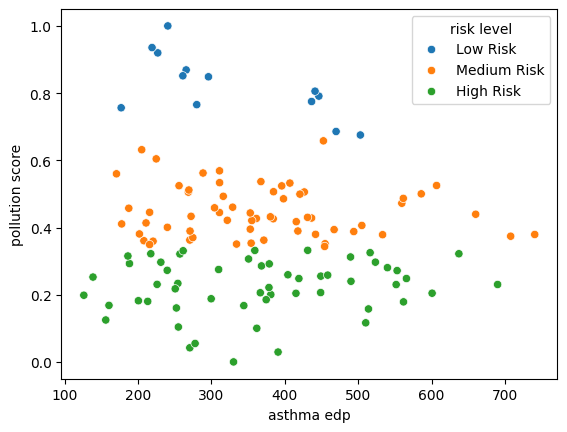

In [7]:
# Scale then combine pollutant values into a single pollution score. Scale this score to 0-1
scaler = MinMaxScaler()
df[pollutant_columns] = scaler.fit_transform(df[pollutant_columns])
df['pollution score'] = scaler.fit_transform(df[pollutant_columns].sum(axis=1).values.reshape(-1, 1))
df = df.drop(pollutant_columns, axis=1)
df

# Calculate the correlation between 'asthma edp' and 'pollution score'
correlation = df[health_stat_columns].corr(df['pollution score'])

# Multiply the correlation by the pollution score to determine it's health risk score
df['health risk score'] = df['pollution score'] * correlation
df['health risk score'] = scaler.fit_transform(df['health risk score'].values.reshape(-1, 1))

bins = [-0.1, 0.33, 0.66, 1]
labels = ['Low Risk', 'Medium Risk', 'High Risk']

# Categorize the 'health risk score' based on the thresholds
df['risk level'] = pd.cut(df['health risk score'], bins=bins, labels=labels)


# dispay asthma vs. pollution score
display(df.min(),df.max(),df.describe(),df)
sns.scatterplot(x=df['asthma edp'],y=df['pollution score'], hue=df['risk level'])
plt.show()


## Model Training

- Split the data up into features and targets, and into training/test sets.
- Scale the features for the training and testing sets.
- Determine the optimal k-value for training.

KNeighborsClassifier(n_neighbors=13)

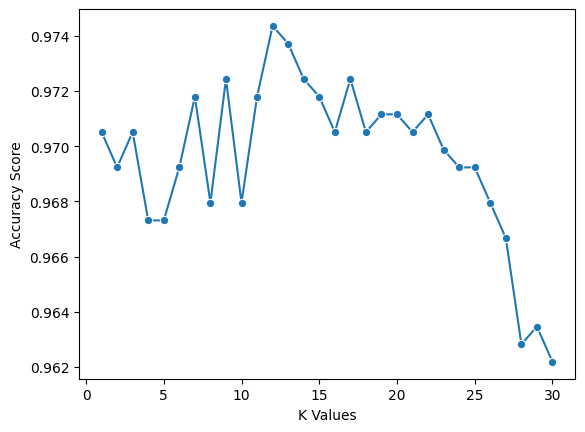

In [3]:
# Split the data into features (X) and target (y)
X = df.drop(['year-month','lhd','health risk score','risk level'], axis=1)
y = df['risk level']

## Map the risk levels to numbers for plotting
risk_mapping = {'Low Risk': 0, 'Medium Risk': 1, 'High Risk': 2}
y_numeric = y.map(risk_mapping)

# Split the data into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Determine the best K Value
k_values = [i for i in range (1,31)]
scores = []
scaler = StandardScaler()
X = scaler.fit_transform(X)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))

# Plot the K-values.
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

# Train the K-NN model
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train, y_train)

## Model Testing

Use the model to predict based on test data.

In [4]:
# Make predictions
y_pred = knn.predict(X_test)

## Model Performance

- Print the models performance metrics
- Generate and display the confusion matrix.
- Generate and display the decision boundaries.

Accuracy: 0.9807692307692307
              precision    recall  f1-score   support

    Low Risk       1.00      0.90      0.95        20
 Medium Risk       0.97      0.99      0.98       142
   High Risk       0.99      0.99      0.99       150

    accuracy                           0.98       312
   macro avg       0.99      0.96      0.97       312
weighted avg       0.98      0.98      0.98       312



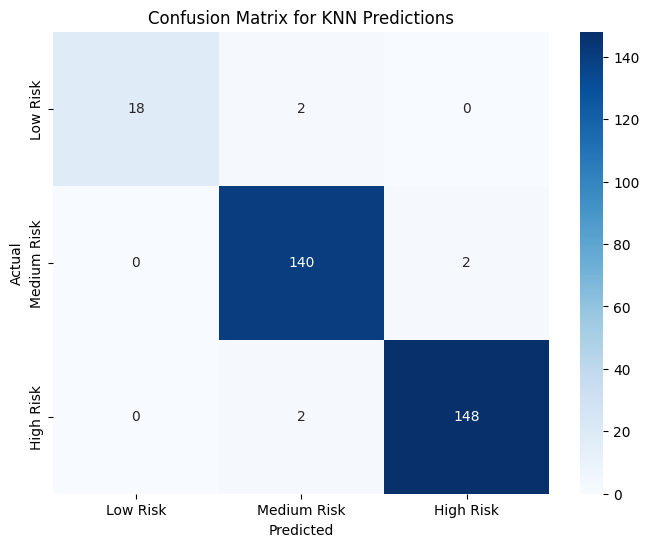

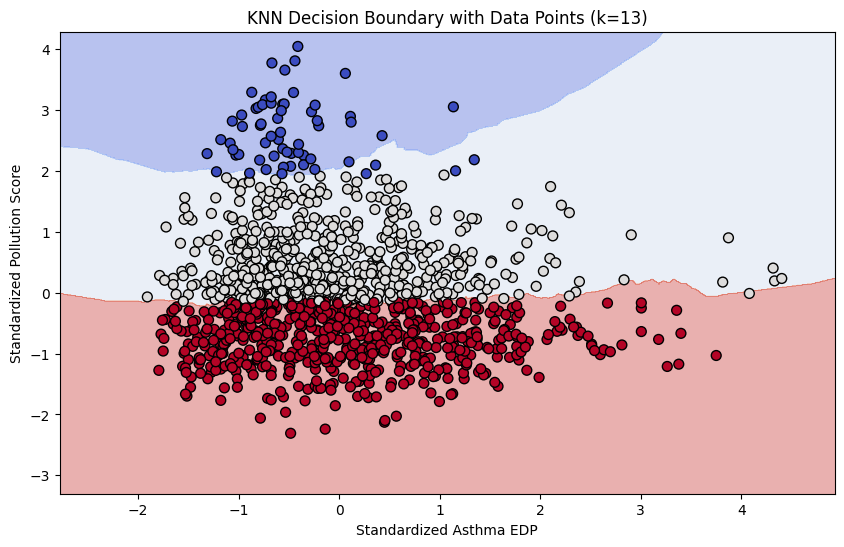

In [5]:

# print performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred, target_names=labels))

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for KNN Predictions')
plt.show()


# Create a mesh grid for plotting decision boundary
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict for each point in the mesh grid
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 6))

# Plot the decision boundary with contourf
plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')

# Overlay the training data points with a scatter plot
plt.scatter(X_train[:, 0], X_train[:, 1], 
            c=y_train, cmap='coolwarm', edgecolor='k', s=50)

# Label axes and title
plt.xlabel('Standardized Asthma EDP')
plt.ylabel('Standardized Pollution Score')
plt.title('KNN Decision Boundary with Data Points (k=13)')

# Show the plot
plt.show()